In [18]:
!pip install obspy gdown

In [19]:
%matplotlib inline 
import numpy as np
import scipy.fft as ft
import matplotlib.pyplot as plt
import obspy
import csv
import ipywidgets as widgets
import pandas as pd 

In [20]:
df = pd.read_csv("Surface_DAS_DTS_UTM_coordinates.csv")
print(df.head())  

  Channel        X        Y        Z
0  number  UTM [m]  UTM [m]  UTM [m]
1     -20        0        0        0
2     -19        0        0        0
3     -18        0        0        0
4     -17        0        0        0


In [21]:
import csv
import numpy as np

rowmin = 53
rowmax = 8673
nRows = rowmax - rowmin + 1  # Corrected calculation

ch = np.zeros(nRows, dtype=np.int32)  # Use np.int32 instead of np.int
x = np.zeros(nRows, dtype=np.float32)
y = np.zeros(nRows, dtype=np.float32)

file_path = "Surface_DAS_DTS_UTM_coordinates.csv"  # Specify the correct file path

with open(file_path, 'r') as myfile:  # Corrected file opening syntax
    myreader = csv.reader(myfile, delimiter=',')  # Fixed syntax
    myfile.seek(0)  # Not needed at the beginning

    rowCtr = 1  # Counter to track row number
    for row in myreader:
        if rowmin <= rowCtr <= rowmax:  # Corrected condition
            index = rowCtr - rowmin  # Adjust index to fit array size
            ch[index] = int(row[0])  # Store channel indices
            x[index] = float(row[1])  # Store x location
            y[index] = float(row[2])  # Store y location
        rowCtr += 1  # Increment row counter


In [22]:
print(ch.shape)
print(x.shape)
print(y.shape)

(8621,)
(8621,)
(8621,)


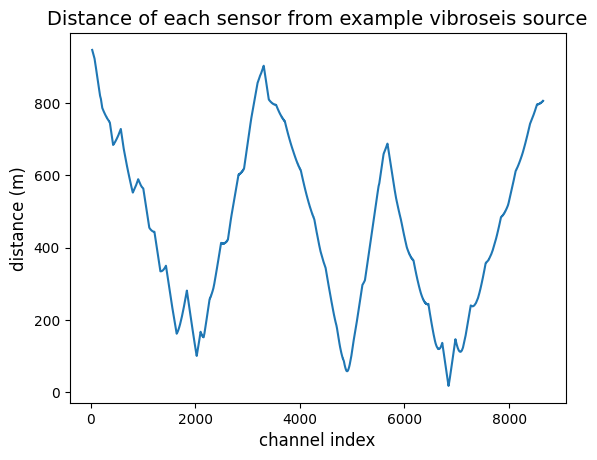

In [23]:
# location of source from https://gdr.openei.org/submissions/849
# converted to UTM by https://www.latlong.net/lat-long-utm.html
srcX = 328552.49  # example source's x location in UTM meters 
srcY = 4408006.65 # example source's y location in UTM meters 

# calculate distances in meters of each sensor from the source location
distances = np.sqrt((x-srcX)**2 + (y-srcY)**2)
plt.plot(ch,distances)
plt.xlabel("channel index",fontsize=12)
plt.ylabel("distance (m)",fontsize=12)
plt.title("Distance of each sensor from example vibroseis source",fontsize=14)
plt.show()

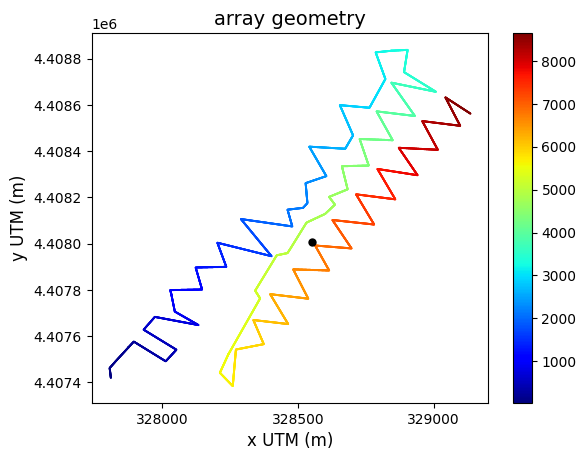

In [24]:
plt.scatter(x,y,c=ch,linewidth=0,s=2,cmap=plt.get_cmap('jet'))
plt.colorbar()
plt.xlabel('x UTM (m)', fontsize=12)
plt.locator_params(axis='x', nbins=5) # reduce number of tick marks so labels aren't so crowded
plt.ylabel('y UTM (m)', fontsize=12)
plt.title('array geometry', fontsize=14)
plt.scatter(srcX,srcY,c='k',linewidth=0)
plt.show()

In [25]:
!wget https://gdr.openei.org/files/849/PoroTomo_iDAS16043_160325140048.sgy

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [26]:
chNumberFor0thTrace = -20 # just as a note- had to look in the csv file to know this (specific to this dataset's channel/geometry mapping info)
startTrNumber = rowmin # for full array 
endTrNumber =  rowmax # for full array
nTr = endTrNumber-startTrNumber+1 

# open up the SEGY file using Obspy
datafile = "PoroTomo_iDAS16043_160325140118.sgy"
# Read the file:
import obspy.io.segy.core
st = obspy.io.segy.core._read_segy(datafile, format='segy', unpack_trace_headers=True)
# Below is an alternative way to read:
#st = obspy.read(datafile,format='SEGY') # st is a stream and it has thousands of traces in it

# get header info from first channel (trace) of interest 
stats = st[startTrNumber].stats
samplesPerSecond = stats.sampling_rate
secondsPerRecord = stats.npts*stats.delta
nSamples = stats.npts

# To try yourself: print out all of these stats and see what other information
# you can get about the dataset. 

# create an empty 2D numpy array to store data 
# (rows correspond to channel, columns correspond to time)
data = np.zeros((nTr,nSamples))

# read data from all channels and store in the numpy array
for tr in range(startTrNumber,endTrNumber+1):
	data[tr-startTrNumber,:] = st[tr].data

In [27]:
stats

         network: 
         station: 
        location: 
         channel: 
       starttime: 2016-03-25T14:01:18.000000Z
         endtime: 2016-03-25T14:01:47.999000Z
   sampling_rate: 1000.0
           delta: 0.001
            npts: 30000
           calib: 1.0
            segy: AttribDict({'trace_header': AttribDict({'endian': '>', 'unpacked_header': None, 'trace_sequence_number_within_line': 54, 'trace_sequence_number_within_segy_file': 54, 'original_field_record_number': 0, 'trace_number_within_the_original_field_record': 329, 'energy_source_point_number': 0, 'ensemble_number': 0, 'trace_number_within_the_ensemble': 0, 'trace_identification_code': 1, 'number_of_vertically_summed_traces_yielding_this_trace': 0, 'number_of_horizontally_stacked_traces_yielding_this_trace': 0, 'data_use': 1, 'distance_from_center_of_the_source_point_to_the_center_of_the_receiver_group': 0, 'receiver_group_elevation': 1227697, 'surface_elevation_at_source': 0, 'source_depth_below_surface': 0, 'datum_ele

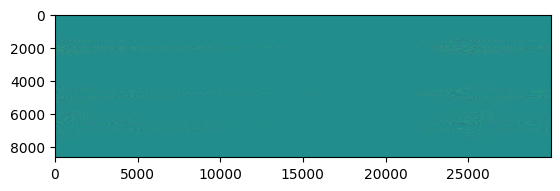

In [28]:
plt.imshow(data)
plt.show()

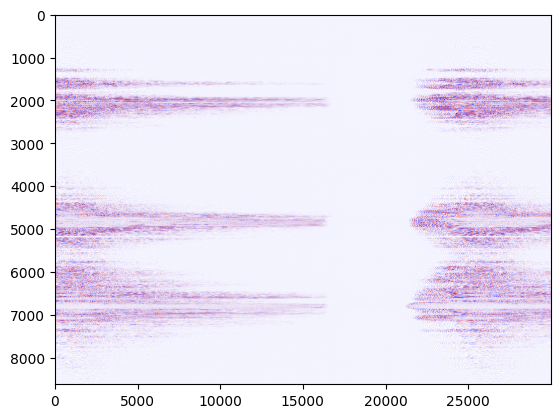

In [29]:
plt.imshow(data,aspect='auto',cmap='seismic')
plt.show()
  

In [30]:
plt.imshow(data,aspect='auto',cmap='seismic')

In [31]:
print("x has "+str(x.size)+" entries")
print("y has "+str(y.size)+" entries")
print("ch has "+str(ch.size)+" entries")
print("data array dimensions are: "+str(data.shape))

x has 8621 entries
y has 8621 entries
ch has 8621 entries
data array dimensions are: (8621, 30000)


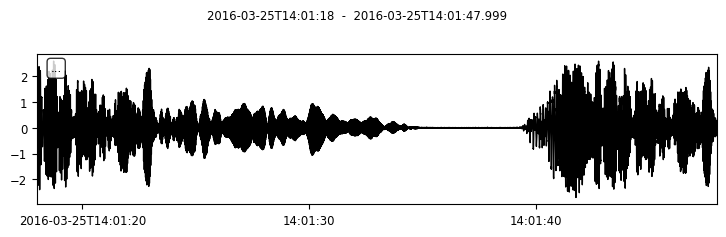

In [48]:
st[2000].plot();

In [33]:
def plotSpaceTime(someData,minSec,maxSec,minCh,maxCh,title,sampleRate):
  # Basic error checking
  if (minSec >= maxSec) or (minSec < 0) or (maxSec*sampleRate > someData.shape[1]):
    print("ERROR in plotSpaceTime inputs minSec: "+str(minSec)+" or maxSec: "+str(maxSec))
    return
  if (minCh >= maxCh) or (minCh < 0) or (maxCh > someData.shape[0]):
    print("Error in plotSpaceTime inputs minCh: "+str(minCh)+" or maxCh: "+str(maxCh)+" referring to array with "+str(someData.shape[0])+" channels.")
    return
  
  # turn time range (in seconds) to indices
  minSecID = int(minSec*sampleRate) 
  maxSecID = int(maxSec*sampleRate) 
  # make the plot
  plt.figure()
  plt.imshow(someData[minCh:maxCh,minSecID:maxSecID],aspect='auto',interpolation='none',cmap='seismic',extent=(minSec,maxSec,maxCh,minCh))
  plt.xlabel('time (s)',fontsize=12)
  plt.ylabel('channel',fontsize=12)
  plt.title(title,fontsize=14)
  plt.colorbar()

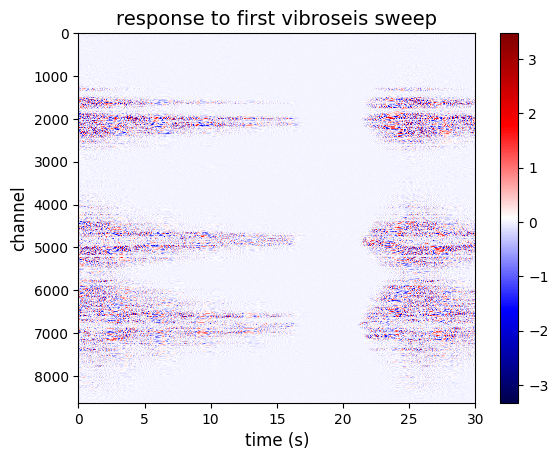

In [34]:
title='response to first vibroseis sweep'
beginningCh = 0
endingCh = nTr
plotSpaceTime(data, 0, secondsPerRecord, beginningCh, endingCh, title, samplesPerSecond) # call the actual plotting function
plt.show()

The next step is for verification if for some reason if the plot don't show

Data shape: (8621, 30000)
Seconds per record: 30.0
Samples per second: 1000.0
Beginning Channel: 0, Ending Channel: 8621


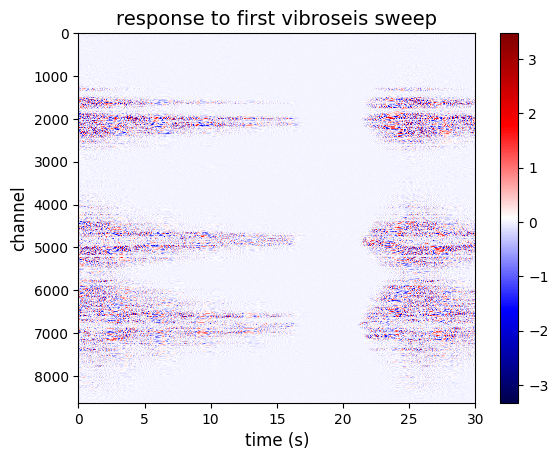

In [35]:
print(f"Data shape: {data.shape if hasattr(data, 'shape') else 'Unknown'}")
print(f"Seconds per record: {secondsPerRecord}")
print(f"Samples per second: {samplesPerSecond}")
print(f"Beginning Channel: {beginningCh}, Ending Channel: {endingCh}")

plotSpaceTime(data, 0, secondsPerRecord, beginningCh, endingCh, title, samplesPerSecond)

import matplotlib.pyplot as plt
plt.show()


In [36]:
def plotTimeSnapshot(xLocs, yLocs, dataChT, timeInSeconds, sampleRate, subsample=1, clip=0):
  # Basic error checking
  if (xLocs.size != yLocs.size) or (xLocs.size != dataChT.shape[0]):
    print("ERROR in plotTimeSnapshot inputs. Dimensions of xLocs, yLocs and rows of dataChT must match.")
    return
  maxTimeAvailable = float(dataChT.shape[1])/sampleRate # maximum time represented in dataChT (seconds)
  if (timeInSeconds < 0) or (timeInSeconds > maxTimeAvailable):
    print("ERROR in plotTimeSnapshot inputs. timeInSeconds "+str(timeInSeconds)+" is not represented in dataChT.")
    return

  # time sample of interest
  timeID = int(timeInSeconds*sampleRate)

  # default color clipping behavior is to just set the max color value to the max absolute value in this snapshot
  if(clip == 0):
    clip = np.max(np.absolute(dataChT[:,timeID])) 

  plt.figure()
  plt.scatter(xLocs[::subsample],yLocs[::subsample],c=dataChT[::subsample,timeID],linewidth=0,s=2,cmap='seismic',vmin=-clip,vmax=clip)
  plt.colorbar()
  plt.xlabel('x UTM (m)')
  plt.locator_params(axis='x', nbins=5) # reduce number of tick marks so labels aren't so crowded
  plt.ylabel('y UTM (m)')
  plt.title('signal at '+str(timeInSeconds)+' seconds',fontsize=14)

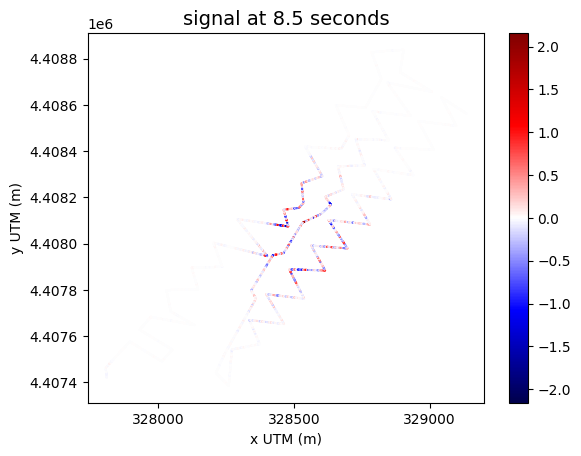

In [51]:
time = 8.5 # time of intereset (in seconds)
plotTimeSnapshot(x, y, data, time, samplesPerSecond)
plt.show()

In [49]:
# set a single  color clip for all time snapshots (so they're all on the same colorscale)
overallClip  = np.percentile(np.absolute(data),99) # take the 99th %tile of absolute values of whole data window as max

def interactiveSnapshot(timeInSec):
  # This is a wrapper around plotTimeSnapshot so that the widget just depends on the 
  # time of interest in seconds. This has no subsampling (so 2nd to last arg is 1).
  plotTimeSnapshot(x, y, data, timeInSec, samplesPerSecond, 1, overallClip)

# has a widget that lets you check the time snapshot at 1, 1.5, 2, 2.5, ..., 24.5, 25 seconds
interactive_plot = widgets.interactive(interactiveSnapshot, timeInSec=(1,25,0.5)) 
interactive_plot

interactive(children=(FloatSlider(value=13.0, description='timeInSec', max=25.0, min=1.0, step=0.5), Output())…

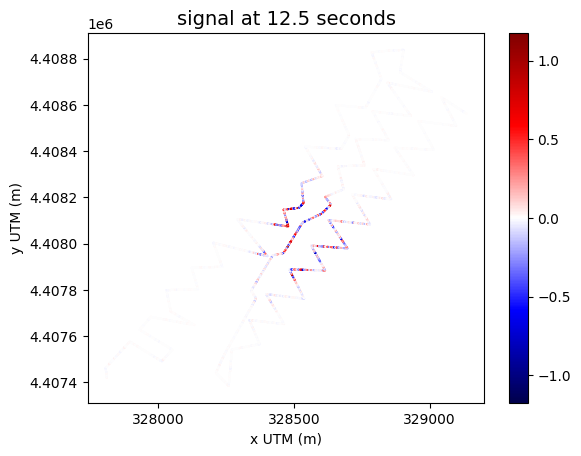

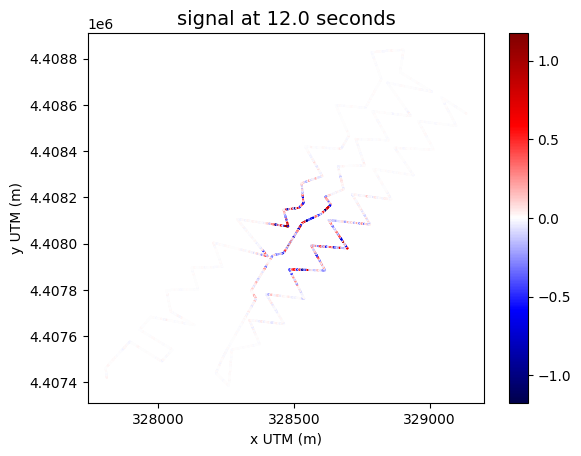

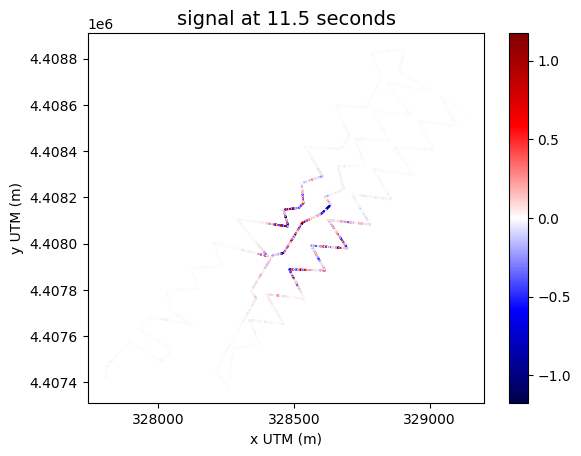

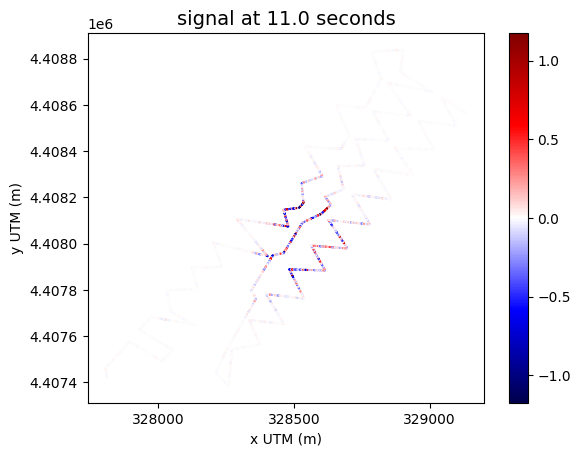

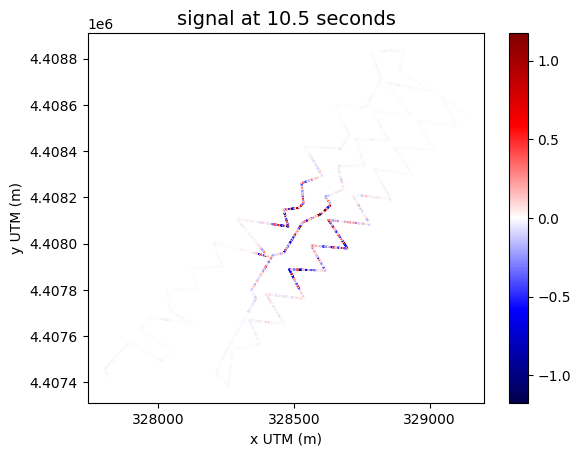

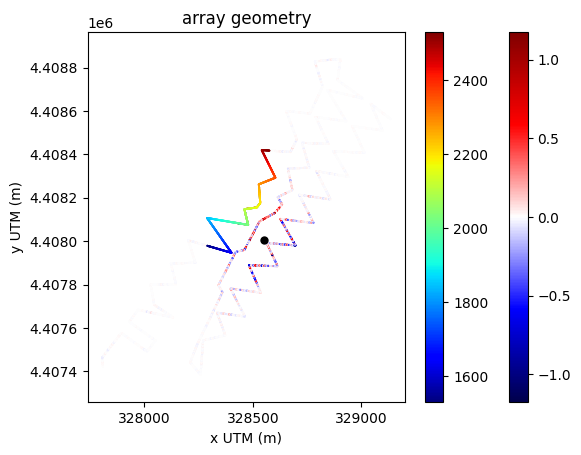

In [52]:
startCh = 1500
endCh = 2500
startSec = 7
endSec=8

plt.scatter(x[startCh:endCh],y[startCh:endCh],c=ch[startCh:endCh],linewidth=0,s=2,cmap=plt.get_cmap('jet'))
plt.colorbar()
plt.xlabel('x UTM (m)') 
plt.locator_params(axis='x', nbins=5)
plt.ylabel('y UTM (m)')
plt.title('array geometry')
plt.scatter(srcX,srcY,c='k',linewidth=0) # plot the source location
plt.axis('equal')
plt.show()

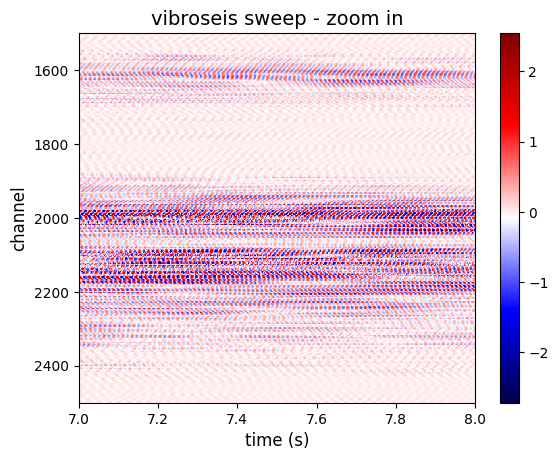

In [40]:
title='vibroseis sweep - zoom in'
plotSpaceTime(data, startSec, endSec, startCh, endCh, title, samplesPerSecond) # call the actual plotting function
plt.show()

In [41]:
def plotSpecOneCh(chOfInterest,dataArray,sampleRate,title): 
  # Basic error checking on inputs
  if(chOfInterest >= dataArray.shape[0]):
    print("ERROR in plotSpecOneCh inputs. Channel requested "+str(chOfInterest)+" not available in data with "+str(dataArray.shape[0])+" channels ")
    return

  spectrum = ft.fft(dataArray[chOfInterest,:])
  frqBins = int(spectrum.size/2)
  # frequencies of interest
  NyquistFrq = sampleRate/2.0 # the Nyquist frequency
  frqs = np.linspace(0,NyquistFrq,num=frqBins)

  plt.figure()
  plt.plot(frqs,np.absolute(spectrum[:frqBins]))
  plt.xlabel('Frequency (Hz)',fontsize=12)
  plt.ylabel('Amplitude',fontsize=12)
  plt.title(title)

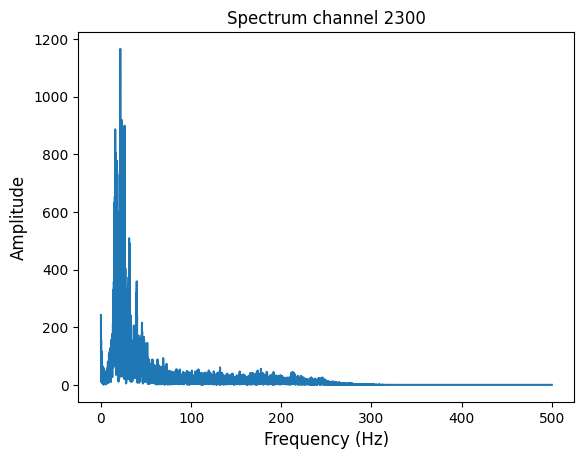

In [42]:
channel = 2300
plotSpecOneCh(channel,data,samplesPerSecond,'Spectrum channel '+str(channel))
plt.show()

In [43]:
def plotArraySpec(dataArray, minSec, maxSec, minCh, maxCh, minFrq, maxFrq, sampleRate, title,  scale='linear'):

  # check for valid inputs (note- these checks aren't exhaustive)
  if(maxFrq <= minFrq):
    print("ERROR in plotArraySpec inputs: minFrq "+str(minFrq)+" >= maxFrq "+str(maxFrq))
    return
  if maxSec <= minSec:
    print("ERROR in plotArraySpec inputs: minSec "+str(minSec)+" >= maxSec "+str(maxSec))
    return
  if (scale != 'linear')  and (scale  != 'log10'): # only 2 scale keywords are recognized
    print("ERROR  in plotArraySpec inputs: scale keyword "+scale+" is not recognized")

  # figure out sample indices for time window of interest
  startTimeIdx =  int(minSec*sampleRate)
  endTimeIdx = int(maxSec*sampleRate)
  if endTimeIdx > dataArray.shape[1]: # another opportunity for error checking: don't request a time bigger than what's available.
    print("ERROR in plotArraySpec inputs: maxSec "+str(maxSec)+" exceeds last time in dataArray")

  # calculate the amplitude spectrum (not amplitude symmetry for +/- frequencies)
  spectrum = ft.fft(dataArray[minCh:maxCh+1,startTimeIdx:endTimeIdx+1],axis=-1) 
  nFrqBins = int(spectrum.shape[1]/2) # number of frequency bins 
  amplitudeSpec =np.absolute(spectrum[:,:nFrqBins])

  # calculate indices corresponding to the frequencies of interest
  NyquistFrq = sampleRate/2.0 # the Nyquist frequency
  # make sure maxFrq doesn't exceed Nyquist  frequency
  if(maxFrq > NyquistFrq):
    print("ERROR in plotArraySpec inputs: maxFrq "+str(maxFrq)+" >= Nyquist frequency "+str(NyquistFrq)+" indicated by sampleRate "+str(sampleRate))
    return
  # convert frequencies to an index in the array
  HzPerBin = NyquistFrq/float(nFrqBins) 
  minFrqIdx =  int(minFrq/HzPerBin) 
  maxFrqIdx =  int(maxFrq/HzPerBin)
  frqs = np.linspace(minFrqIdx*HzPerBin,maxFrqIdx*HzPerBin,num=(maxFrqIdx-minFrqIdx+1))

  # actually do the plot
  plt.figure()
  if scale  == 'linear':
    plt.imshow(amplitudeSpec[:,minFrqIdx:maxFrqIdx],aspect='auto',interpolation='none',cmap='inferno',extent=(minFrq,maxFrq,maxCh,minCh)) 
  elif scale == 'log10':
    plt.imshow(np.log10(amplitudeSpec[:,minFrqIdx:maxFrqIdx]),aspect='auto',interpolation='none',cmap='inferno',extent=(minFrq,maxFrq,maxCh,minCh)) 
  plt.xlabel('Frequency (Hz)')
  plt.ylabel('Channel')
  plt.colorbar()
  plt.title(title)

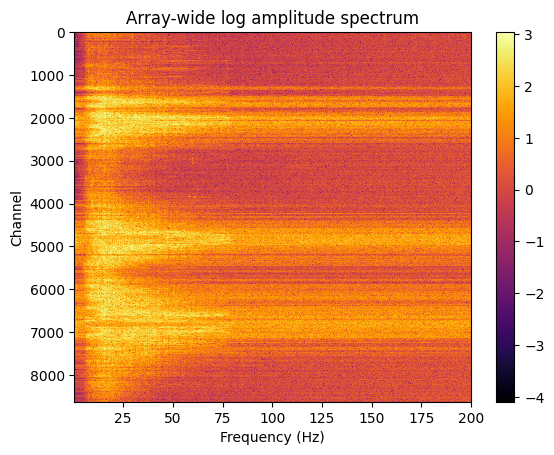

In [44]:
# visualize same channels as you did for whole time domain plot above
# choose frequency range of interest
minFrq = 0.5
maxFrq = 200
# choose which time window to investigate
startSec =  0
endSec = 25
# call the function to plot
plotArraySpec(data, startSec, endSec, beginningCh, endingCh, minFrq, maxFrq, samplesPerSecond, 'Array-wide log amplitude spectrum','log10')
plt.show()

In [45]:
import scipy
startCh = 1500
endCh = 2500
nch,nt = data.shape
swp_time = 20.0
swp_f1 = 5.0
swp_f2 = 80.0
sweep = scipy.signal.chirp(np.linspace(0.0,swp_time,int(swp_time*samplesPerSecond)), swp_f1, 20, swp_f2, method='linear')
sweep = np.flip(sweep)

corr_data = np.zeros(shape=data.shape)
for chind in range(nch):
  corr_data[chind,:] = scipy.signal.convolve(data[chind,:],sweep,mode='same')

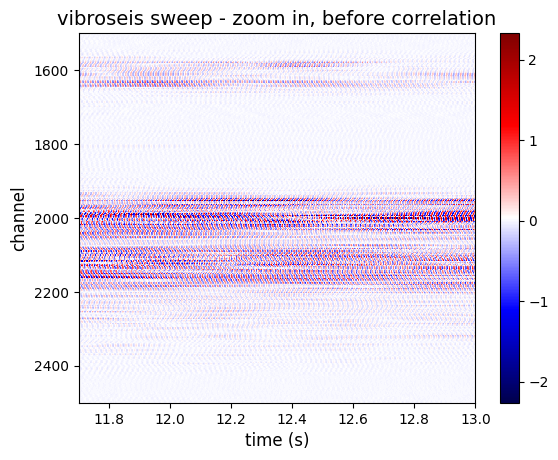

In [46]:

startCh = 1500
endCh = 2500
title='vibroseis sweep - zoom in, before correlation'
plotSpaceTime(data, 11.7, 13, startCh, endCh, title, samplesPerSecond) # call the actual plotting function
plt.show()

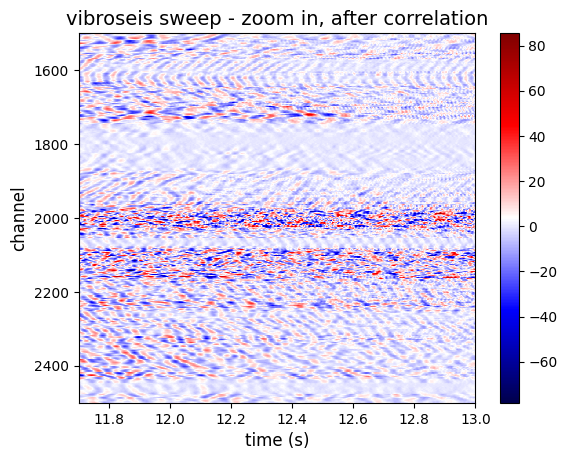

In [47]:
title='vibroseis sweep - zoom in, after correlation'
plotSpaceTime(corr_data, 11.7, 13, startCh, endCh, title, samplesPerSecond) # call the actual plotting function
plt.show()